In [3]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchinfo import summary
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [25]:
batch_size = 64
num_epochs = 5
input_size = 28
seq_len = 28
num_layers = 2
hidden_size = 256
num_classes = 10
learning_rate = 0.01

In [15]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes): 
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size 
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first = True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.dense = nn.Linear(seq_len*hidden_size, num_classes)

    def forward(self, input_tensor):
        h0 = torch.zeros(self.num_layers, input_tensor.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input_tensor.size(0), self.hidden_size).to(device)
        op1, _ = self.rnn(input_tensor, h0)
        # op1, _ = self.gru(input_tensor, h0)
        # op1, _ = self.lstm(input_tensor, (h0, c0))
        op1 = op1.reshape(op1.shape[0], -1) 
        return self.dense(op1)

In [16]:
train = datasets.MNIST("datasets/", download = True, train = True, transform = transforms.ToTensor())
test = datasets.MNIST("datasets/", download = True, train = False, transform = transforms.ToTensor())
train_loader = DataLoader(train, shuffle = True, batch_size = batch_size)
test_loader = DataLoader(test, shuffle = True, batch_size = batch_size)

In [17]:
model = SimpleRNN(input_size, hidden_size, num_layers, num_classes)
print(model)
print()
print(summary(model, input_size = (batch_size, 28, 28)))

SimpleRNN(
  (rnn): RNN(28, 256, num_layers=2, batch_first=True)
  (dense): Linear(in_features=7168, out_features=10, bias=True)
)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleRNN                                [64, 10]                  --
├─RNN: 1-1                               [64, 28, 256]             204,800
├─Linear: 1-2                            [64, 10]                  71,690
Total params: 276,490
Trainable params: 276,490
Non-trainable params: 0
Total mult-adds (M): 371.59
Input size (MB): 0.20
Forward/backward pass size (MB): 3.68
Params size (MB): 1.11
Estimated Total Size (MB): 4.98


In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

print(loss_fn)
print()
print(optimizer)

CrossEntropyLoss()

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [31]:
#Training Loop
model.to(device)
model.train()
losses = []
accuracies = []
loss_epoch = 0
correct = 0
for epoch in tqdm(range(num_epochs)):
    loss_epoch = 0
    correct = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device).squeeze(1), y.to(device)
        y_pred = model(x)
        loss_batch = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

        loss_epoch += loss_batch.item() * x.size(0)
        correct += (y_pred.argmax(1) == y).sum().item()

    losses.append(loss_epoch/len(train_loader.dataset))
    accuracies.append(correct/len(train_loader.dataset) * 100)
    print(f"Epoch: {epoch} | Loss: {loss_epoch/len(train_loader.dataset)} | Accuracy: {correct/len(train_loader.dataset) * 100}")

 20%|██        | 1/5 [00:13<00:53, 13.30s/it]

Epoch: 0 | Loss: 36.077556377156576 | Accuracy: 10.036666666666667


 40%|████      | 2/5 [00:27<00:40, 13.66s/it]

Epoch: 1 | Loss: 36.48153451843262 | Accuracy: 10.038333333333334


 60%|██████    | 3/5 [00:42<00:28, 14.31s/it]

Epoch: 2 | Loss: 36.426102736409504 | Accuracy: 10.08


 80%|████████  | 4/5 [00:56<00:14, 14.28s/it]

Epoch: 3 | Loss: 36.365765553792315 | Accuracy: 10.096666666666666


100%|██████████| 5/5 [01:10<00:00, 14.13s/it]

Epoch: 4 | Loss: 38.06923932495117 | Accuracy: 9.846666666666666


Text(0, 0.5, 'Loss')

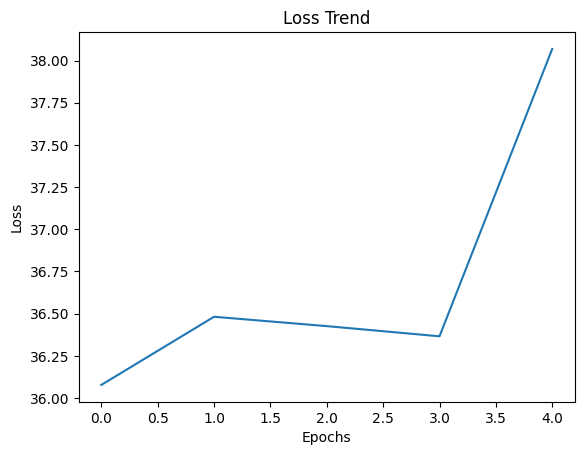

In [32]:
plt.plot(range(num_epochs), losses)
plt.title("Loss Trend")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

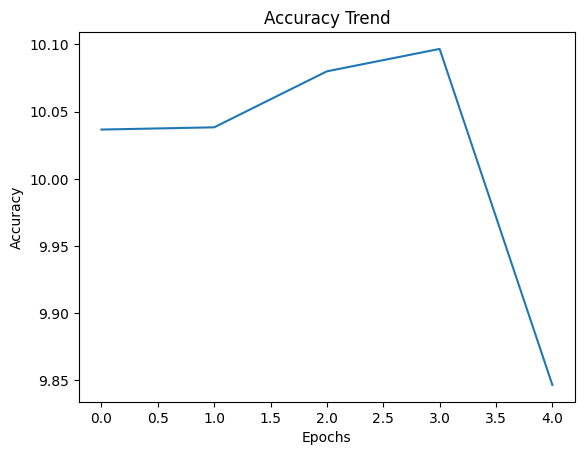

In [33]:
plt.plot(range(num_epochs), accuracies)
plt.title("Accuracy Trend")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [36]:
#Testing Loop
model.eval()
total_loss = 0
correct = 0
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(device).squeeze(1), y.to(device)
        y_pred = model(x)
        loss_batch = loss_fn(y_pred, y)

        total_loss += loss_batch.item() * x.size(0)
        correct += (y_pred.argmax(1) == y).sum().item()

print(f"Loss: {total_loss/len(test_loader.dataset)} | Accuracy: {correct/len(test_loader.dataset) * 100}")

Loss: 35.47266624755859 | Accuracy: 9.82
